# Assignment 2  
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [122]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace


## Image Pre-Processing

### Import All Images
Import low-resolution images from ~/data/  
Import high-resolution images from ~/data_hires/

**Notebook assumes both data and data_hires directories are in the same level as the notebook!

In [ ]:
# Remove borders
def remove_borders(channel, border_percent):
    height, width = channel.shape
    bh = int(height * border_percent)
    bw = int(width * border_percent)
    return channel[bh:height-bh, bw:width-bw]

def load_and_split_image(directory, filename, hires=False, border_percent=0.08):
    """
    Load an image, normalize, split into top/middle/bottom, and remove borders.
    Args:
        directory (str): Directory path.
        filename (str): Image filename.
        hires (bool): True for high-res (.tif), False for low-res (.jpg).
        border_percent (float): Border percentage to crop.
    Returns:
        (top, middle, bottom): Cropped slices as numpy arrays.
    """

    # Load image and normalize
    path = os.path.join(directory, filename)
    image = Image.open(path)
    if hires:
        image_array = np.array(image) / 65535.0
    else:
        image = image.convert('L')
        image_array = np.array(image) / 255.0

    # Split into slices
    h = image_array.shape[0]
    h_per = h // 3
    top    = image_array[0 : h_per, :]
    middle = image_array[h_per : 2*h_per, :]
    bottom = image_array[2*h_per : 3*h_per, :]

    top    = remove_borders(top, border_percent)
    middle = remove_borders(middle, border_percent)
    bottom = remove_borders(bottom, border_percent)

    return top, middle, bottom

In [141]:
# Define directories
data_dir = os.path.join(os.getcwd(), "data")
data_hires_dir = os.path.join(os.getcwd(), "data_hires")

# List all image files
image_files_low_res = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
image_files_high_res = [f for f in os.listdir(data_hires_dir) if f.endswith('.tif')]

# Extract slices for low-resolution images
low_res_slices = []
for filename in image_files_low_res:
    top, middle, bottom = load_and_split_image(data_dir, filename, hires=False)
    low_res_slices.append((top, middle, bottom))

# Extract slices for high-resolution images
high_res_slices = []
for filename in image_files_high_res:
    top, middle, bottom = load_and_split_image(data_hires_dir, filename, hires=True)
    high_res_slices.append((top, middle, bottom))

NameError: name 'remove_borders' is not defined

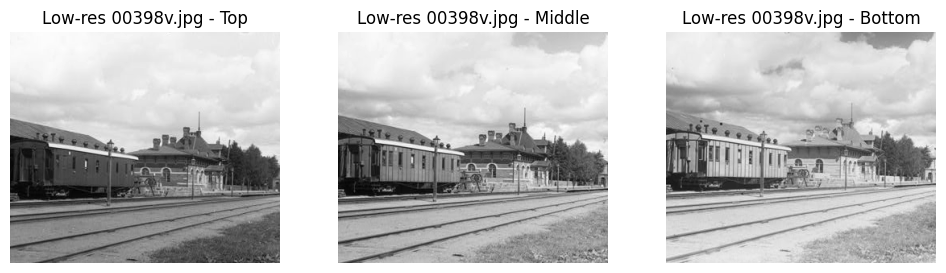

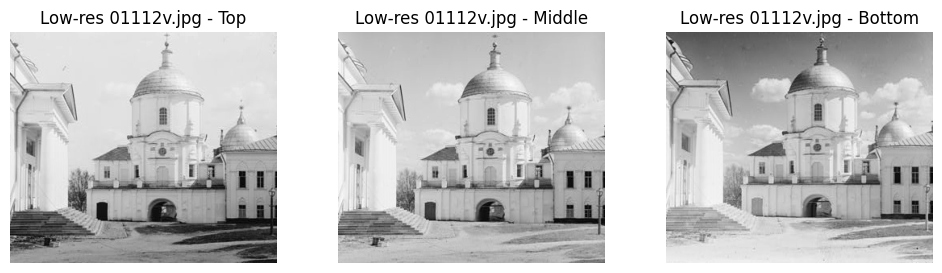

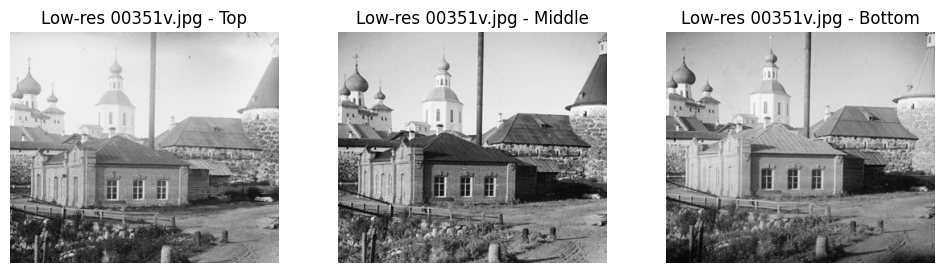

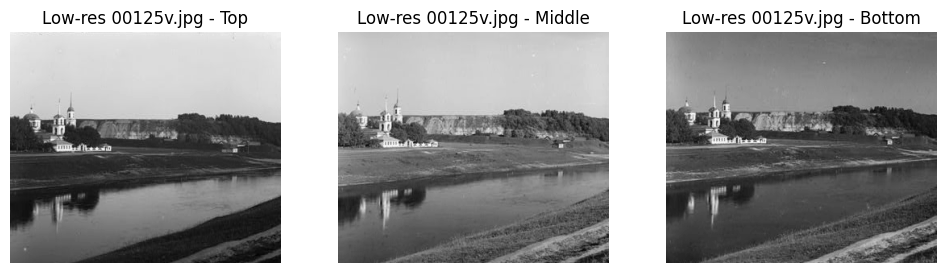

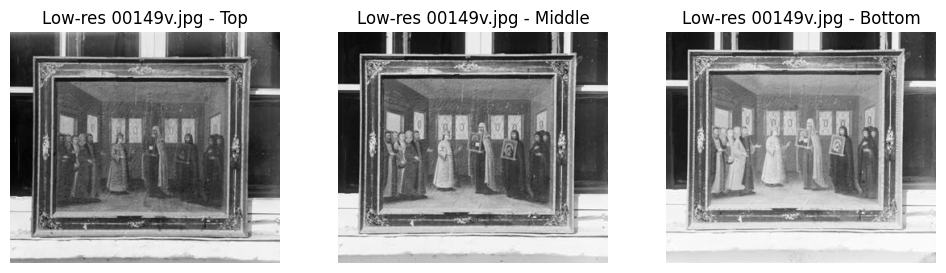

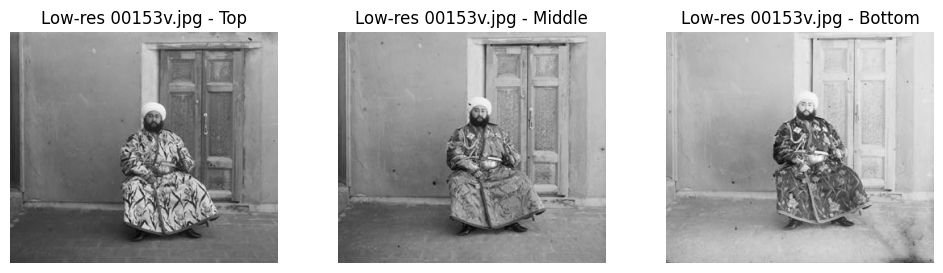

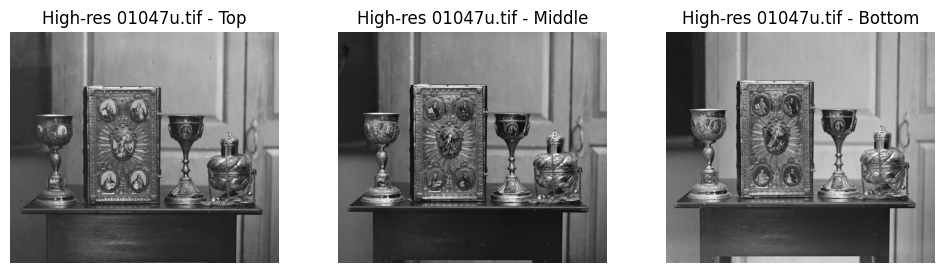

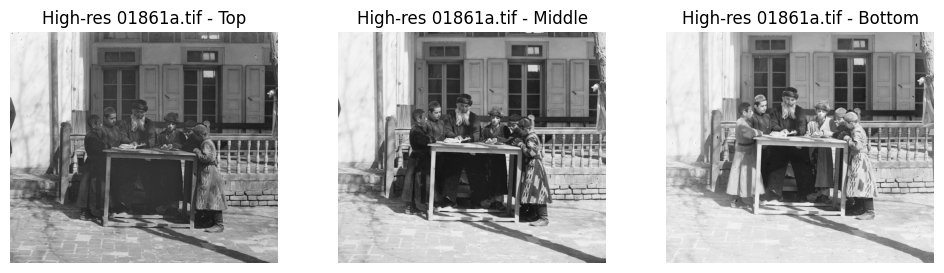

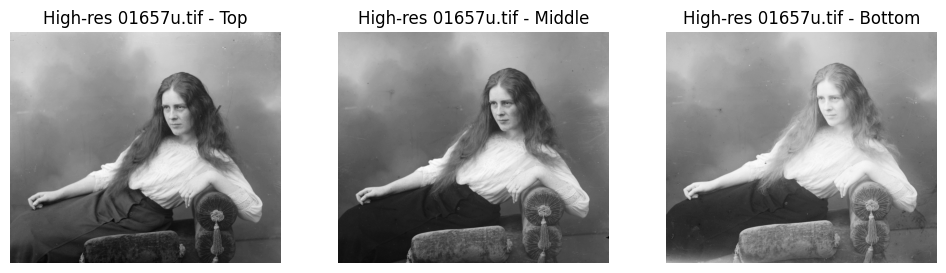

In [125]:
# Plot low-resolution slices next to each other
for i, (top, middle, bottom) in enumerate(low_res_slices):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(top, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Top')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(middle, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Middle')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(bottom, cmap='gray')
    plt.title(f'Low-res {image_files_low_res[i]} - Bottom')
    plt.axis('off')
    plt.show()

# Plot high-resolution slices next to each other
for i, (top, middle, bottom) in enumerate(high_res_slices):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(top, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Top')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(middle, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Middle')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(bottom, cmap='gray')
    plt.title(f'High-res {image_files_high_res[i]} - Bottom')
    plt.axis('off')
    plt.show()

### Fast Fourier Transform Alignment Algorithm
- Compute fourier transforms:
    - Take the FFT on the input channels of the image.
    - For e.g. F_base and F_target.
- Form cross-power spectrum:
    - Compute the product of top_FT1 and complex conjugate of bottom_FT2.
- Inverse transform to correlation space.
    - Take the inverse FFT of the above product to obtain the cross-correlation surface.
- Find the displacement:
    - Locate the position of the maximum value in the correlation surface.
    - This position gives the relative shift (offset) between top and bottom channels.
- Align all channels:
    - Using the mid channel as reference base:
        - Align Top -> Mid
        - Align Bottom -> Mid
- Stack aligned channels:
    - Apply the computed offsets to top and bottom, then stack the channels to form the algined color image


In [ ]:
def fourier_shift_correlation(base, target, visualize_corr=False, title_prefix=""):
    """
    Compute the Fourier shift correlation between base and target images.
    Visualize the inverse FFT (cross-correlation map).
    Returns:
        The shift (dy, dx) needed to align target to base.
    """
    # Ensure floats
    base_f   = base.astype(np.float32, copy=False)
    target_f = target.astype(np.float32, copy=False)

    # 1. Fourier transforms
    FT1 = np.fft.fft2(base_f)
    FT2 = np.fft.fft2(target_f)

    # 2. Multiply by conjugate
    product = FT1 * np.conjugate(FT2)

    # 3. Inverse FFT
    corr = np.fft.ifft2(product)
    corr_mag = np.abs(corr)

    # Visualization (fftshift ONLY for plotting)
    if visualize_corr:
        plt.figure(figsize=(5,5))
        plt.imshow(np.fft.fftshift(corr_mag), cmap='hot')
        plt.title(f"{title_prefix} correlation map")
        plt.colorbar(); plt.show()

    # 4. Peak location -> displacement
    H, W = corr_mag.shape
    peak_row, peak_col = np.unravel_index(np.argmax(corr_mag), corr_mag.shape)

    dy = peak_row if peak_row <= H // 2 else peak_row - H
    dx = peak_col if peak_col <= W // 2 else peak_col - W

    return -int(dy), -int(dx)

In [130]:
def align_and_form_color_images(slices_list, visualize_corr=False):
    """
    For each (top, middle, bottom):
      - treat middle as base (G channel),
      - align top (B) and bottom (R) to middle,
      - stack into RGB.
    """
    color_images = []
    shifts = []

    for idx, (top, middle, bottom) in enumerate(slices_list):
        dy_b, dx_b = fourier_shift_correlation(
            middle, top, visualize_corr=visualize_corr, title_prefix=f"#{idx+1} B→G"
        )
        dy_r, dx_r = fourier_shift_correlation(
            middle, bottom, visualize_corr=visualize_corr, title_prefix=f"#{idx+1} R→G"
        )

        # Apply the shifts
        top_aligned    = np.roll(top,    shift=(-dy_b, -dx_b), axis=(0,1))
        bottom_aligned = np.roll(bottom, shift=(-dy_r, -dx_r), axis=(0,1))
        middle_aligned = middle

        # Stack into RGB (bottom≈R, middle≈G, top≈B)
        rgb = np.dstack([bottom_aligned, middle_aligned, top_aligned])
        color_images.append(rgb)

        shifts.append({"B->G": (dy_b, dx_b), "R->G": (dy_r, dx_r)})

    return color_images, shifts

00398v.jpg shifts: {'B->G': (-5, -3), 'R->G': (6, 1)}


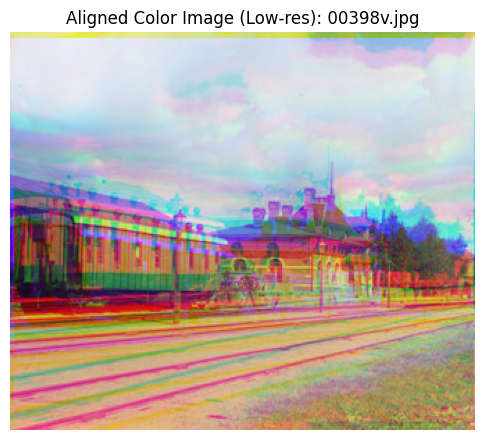

01112v.jpg shifts: {'B->G': (0, 0), 'R->G': (5, 1)}


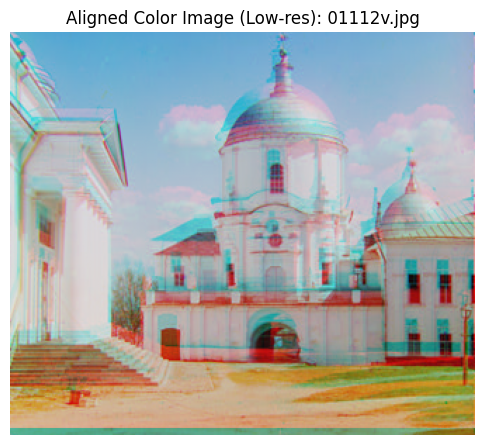

00351v.jpg shifts: {'B->G': (-4, -1), 'R->G': (9, 1)}


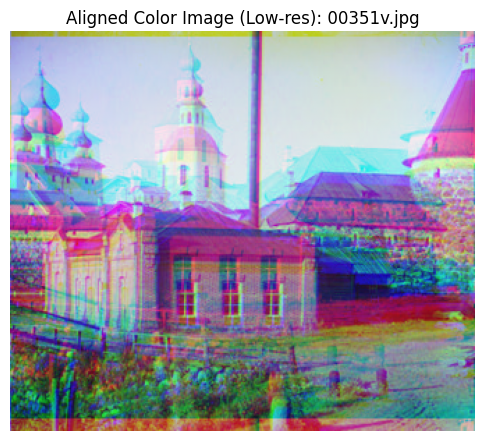

00125v.jpg shifts: {'B->G': (-5, -2), 'R->G': (4, -1)}


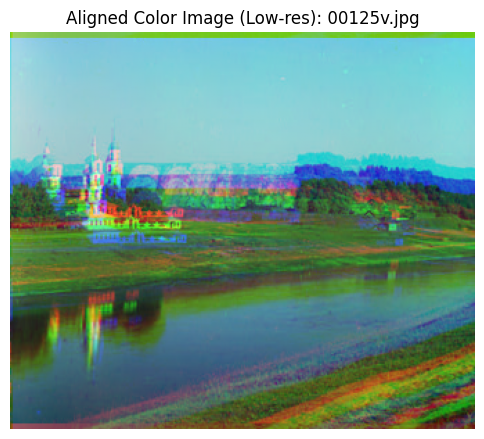

00149v.jpg shifts: {'B->G': (-4, -2), 'R->G': (5, 0)}


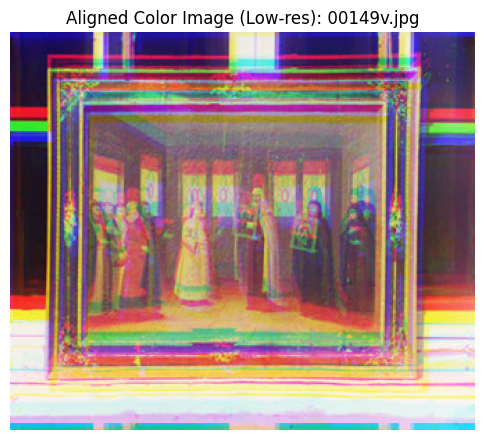

00153v.jpg shifts: {'B->G': (-7, -2), 'R->G': (7, 2)}


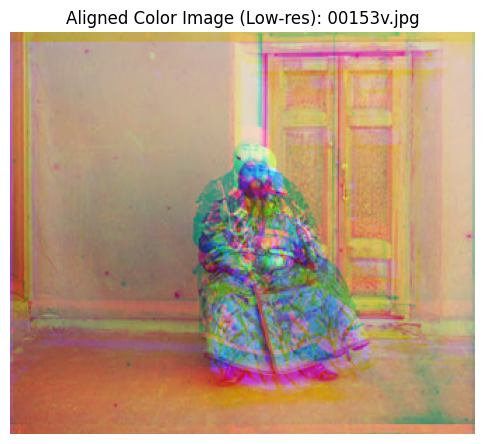

In [131]:
aligned_low_res_images, low_res_shifts = align_and_form_color_images(
    low_res_slices, visualize_corr=False
)

for i, color_image in enumerate(aligned_low_res_images):
    plt.figure(figsize=(6,6))
    plt.imshow(color_image)
    plt.title(f"Aligned Color Image (Low-res): {image_files_low_res[i]}")
    plt.axis('off')
    print(f"{image_files_low_res[i]} shifts:", low_res_shifts[i])
    plt.show()

### Color Channel Preprocessing
- There are faulty alignments in the aligned color imaged 
- To adress this issue apply a small Laplacian of Gaussian filter to highlight edges in each color channel

In [132]:
def preprocess_channel(img, mode="log", sigma=1.0, amount=1.0):
    """Assignment-allowed preprocessing: 'log' for Laplacian-of-Gaussian,
       or 'unsharp' for mild sharpening. Returns float32."""
    x = img.astype(np.float32, copy=False)
    if mode == "log":           # edge emphasis
        # LoG can be positive/negative; magnitude works well for correlation
        return np.abs(gaussian_laplace(x, sigma=sigma))
    elif mode == "unsharp":     # x + amount*(x - blur(x))
        blur = gaussian_filter(x, sigma=sigma)
        return x + amount * (x - blur)
    else:
        return x

In [138]:
# Re-define the align_and_form_color_images function to include preprocessing
def align_and_form_color_images_with_preprocessing(
        slices_list, 
        preprocess="log",
        sigma=1.0, 
        visualize_corr=False):
    color_images, shifts_all = [], []
    for i, (top, middle, bottom) in enumerate(slices_list):
        # assignment-allowed preprocessing
        Bp = preprocess_channel(top,    mode=preprocess, sigma=sigma)
        Gp = preprocess_channel(middle, mode=preprocess, sigma=sigma)
        Rp = preprocess_channel(bottom, mode=preprocess, sigma=sigma)

        # correlate G (base) vs B and R (targets)
        dyB, dxB = fourier_shift_correlation(Gp, Bp, visualize_corr=visualize_corr,
                                             title_prefix=f"#{i+1} B→G")
        dyR, dxR = fourier_shift_correlation(Gp, Rp, visualize_corr=visualize_corr,
                                             title_prefix=f"#{i+1} R→G")

        # shift TARGETS by (-dy, -dx)
        B_aligned = np.roll(top,    shift=(-dyB, -dxB), axis=(0,1))
        R_aligned = np.roll(bottom, shift=(-dyR, -dxR), axis=(0,1))
        G_aligned = middle

        rgb = np.dstack([R_aligned, G_aligned, B_aligned])  # [R,G,B]
        color_images.append(rgb)
        shifts_all.append({"B->G": (dyB, dxB), "R->G": (dyR, dxR)})
        print(f"Image {i+1}: B->G {dyB,dxB} | R->G {dyR,dxR}")

    return color_images, shifts_all

### Color Image Alginment for Low-Resolution Images

Image 1: B->G (-5, -3) | R->G (6, 1)
Image 2: B->G (0, 0) | R->G (5, 1)
Image 3: B->G (-4, -1) | R->G (9, 1)
Image 4: B->G (-5, -2) | R->G (4, -1)
Image 5: B->G (-4, -2) | R->G (5, 0)
Image 6: B->G (-7, -2) | R->G (7, 2)
00398v.jpg shifts: {'B->G': (-5, -3), 'R->G': (6, 1)}


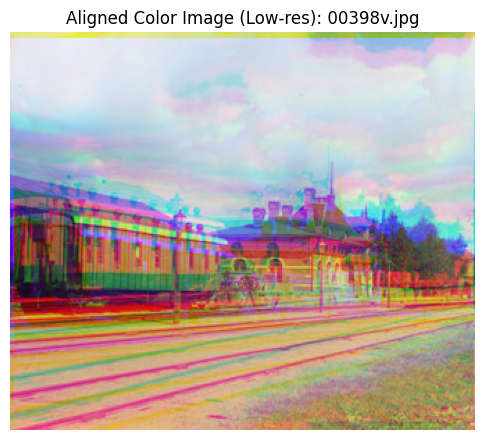

01112v.jpg shifts: {'B->G': (0, 0), 'R->G': (5, 1)}


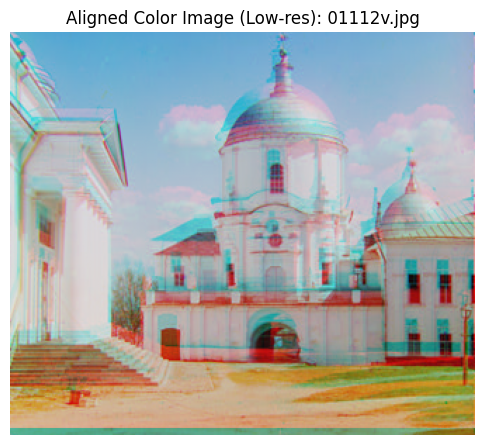

00351v.jpg shifts: {'B->G': (-4, -1), 'R->G': (9, 1)}


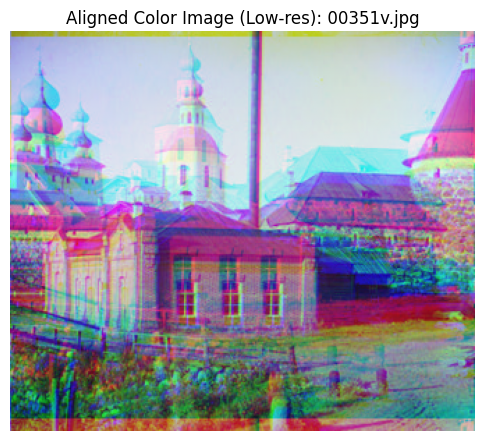

00125v.jpg shifts: {'B->G': (-5, -2), 'R->G': (4, -1)}


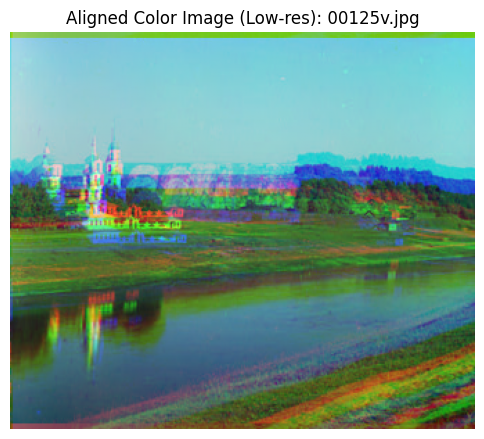

00149v.jpg shifts: {'B->G': (-4, -2), 'R->G': (5, 0)}


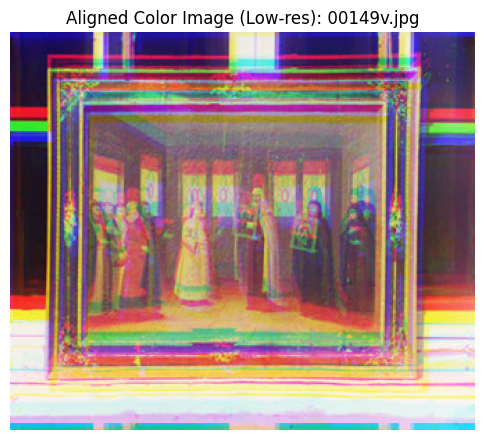

00153v.jpg shifts: {'B->G': (-7, -2), 'R->G': (7, 2)}


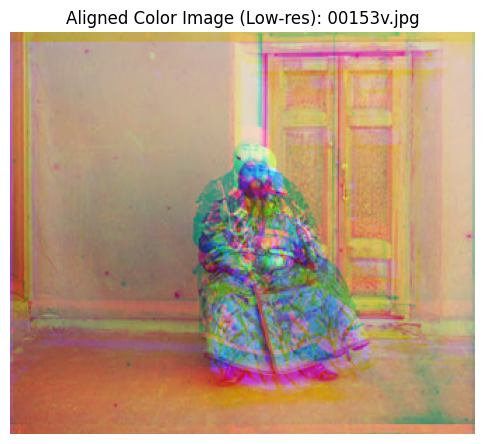

In [139]:
# Align and form color images for low-res images with preprocessing
aligned_low_res_images, low_res_shifts = align_and_form_color_images_with_preprocessing(
    low_res_slices,
    preprocess="gaussian",    
    sigma=1.0,
    visualize_corr=False
)

for i, color_image in enumerate(aligned_low_res_images):
    plt.figure(figsize=(6,6))
    plt.imshow(color_image)
    plt.title(f'Aligned Color Image (Low-res): {image_files_low_res[i]}')
    plt.axis('off')
    print(f'{image_files_low_res[i]} shifts:', low_res_shifts[i])
    plt.show()